## General information

Data in dataset provided is collected from [Pamyat Naroda](https://foto.pamyat-naroda.ru) website. At the time of downloading the site contained information about ~2.3 million Soviet citizens who participated in World War II. About half of this data was downloaded and processed, so we have about 1.1 million of unique persons.

Data contains personal information (name, birth date, birth place, death date, photo) and information about military service (rank, conscription info, service place, bio).

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from io import BytesIO
import requests
from random import sample

In [2]:
df = pd.read_csv('data.csv.zip')

In [3]:
print(f'Data has {df.shape[0]} rows and {df.shape[1]} columns.')

Data has 1159671 rows and 11 columns.


In [4]:
df.head()

,data_id,photo,name,birth_date,birth_place,conscription_place,conscription_date,rank,duty_place,death_date,bio
0,1829796,https://roadheroes.storage.yandexcloud.net/a6d...,Гусев Николай Михайлович,19.12.1913,сведений нет,сведений нет,1942,рядовой,сведений нет,сведений нет,сведений нет
1,1847513,https://roadheroes.storage.yandexcloud.net/b8f...,Ахметзянов Гайса Ахметзянович,1899,"ТАССР, Пестречинский район, с. Ленино-Кокушкино","ТАССР, Пестречинский РВК",1941,сведений нет,сведений нет,1965,сведений нет
2,1863504,https://roadheroes.storage.yandexcloud.net/89b...,Ярошенко Андрей Павлович,14.10.1914,"с. Львовское, Северского р-на, Краснодарского ...",Краснодарским РВК,07.1941,старший матрос,NaN,21.02.2001,NaN
3,1831171,https://roadheroes.storage.yandexcloud.net/7c2...,Бирюков Афанасий Дмитриевич,20.02.1915,д.Воропаево Курская область,Дмитриевский РВК,15.10.1934,подполковник,NaN,31.08.2001,"Медаль ""За боевые заслуги"", ""За победу над Гер..."
4,1840228,https://roadheroes.storage.yandexcloud.net/80f...,Пономарев Павел Яковлеич,1924 29 декабря,Башкирия дер-я Тастуба,Башкирия Дуванский р-он,1942 4 сентября,офицер,Германия / ГДР/,2006 1 февраля,NaN


## Data exploration

### data_id

**data_id** column contains a unique id from the [Pamyat Naroda](https://foto.pamyat-naroda.ru) website. Using URL of format `https://foto.pamyat-naroda.ru/detail/data_id` one will get the corresponding site page.

### photo

**photo** column contains url to photo. If image is missed it contains url `https://foto.pamyat-naroda.ru/frontend/assets/image/no-photo.jpg`.

In [5]:
MISSING_IMAGE = 'https://foto.pamyat-naroda.ru/frontend/assets/image/no-photo.jpg'

In [6]:
df['photo'].value_counts()

https://foto.pamyat-naroda.ru/frontend/assets/image/no-photo.jpg                        496775
https://roadheroes.storage.yandexcloud.net/1c8d3921979ec099028e4552e07b28e2_crop.jpg         2
https://roadheroes.storage.yandexcloud.net/2e23f668a74d9f47da0c5a00dae9d960_crop.jpg         2
https://roadheroes.storage.yandexcloud.net/d5857417161cf1d4d13f0139d01aba98_crop.jpg         2
https://roadheroes.storage.yandexcloud.net/acb48ce37f28729d143de3cf0e3b708c_crop.jpg         1
                                                                                         ...  
https://roadheroes.storage.yandexcloud.net/19096b5a8403990c5f8748308c264079_crop.jpg         1
https://roadheroes.storage.yandexcloud.net/032a7318850abf97b9d04d1e7e3b2807_crop.jpg         1
https://roadheroes.storage.yandexcloud.net/0c1d4e2b1c5d70ace9dabfdd6527fe54_crop.jpg         1
https://roadheroes.storage.yandexcloud.net/80f731e4802a97372baf8d9d785d4bfc_crop.jpg         1
https://roadheroes.storage.yandexcloud.net/bbb343e

As we can see, photo is provided for 57% of persons. There are 3 cases then different records have same photo. In all this cases it is the same person uploaded multiple times. Example:

In [7]:
df[df['photo'] == 'https://roadheroes.storage.yandexcloud.net/1c8d3921979ec099028e4552e07b28e2_crop.jpg']

,data_id,photo,name,birth_date,birth_place,conscription_place,conscription_date,rank,duty_place,death_date,bio
208930,2003203,https://roadheroes.storage.yandexcloud.net/1c8...,Арефьев Петр Иванович,1912,NaN,NaN,NaN,капитан,3 фр троф б-да 4 Укр.фр.,NaN,NaN
276484,2003233,https://roadheroes.storage.yandexcloud.net/1c8...,Арефьев Петр Иванович,1912,NaN,NaN,NaN,капитан,3 фр троф б-да 4 Укр.фр.,NaN,NaN


Let's look at the photos:

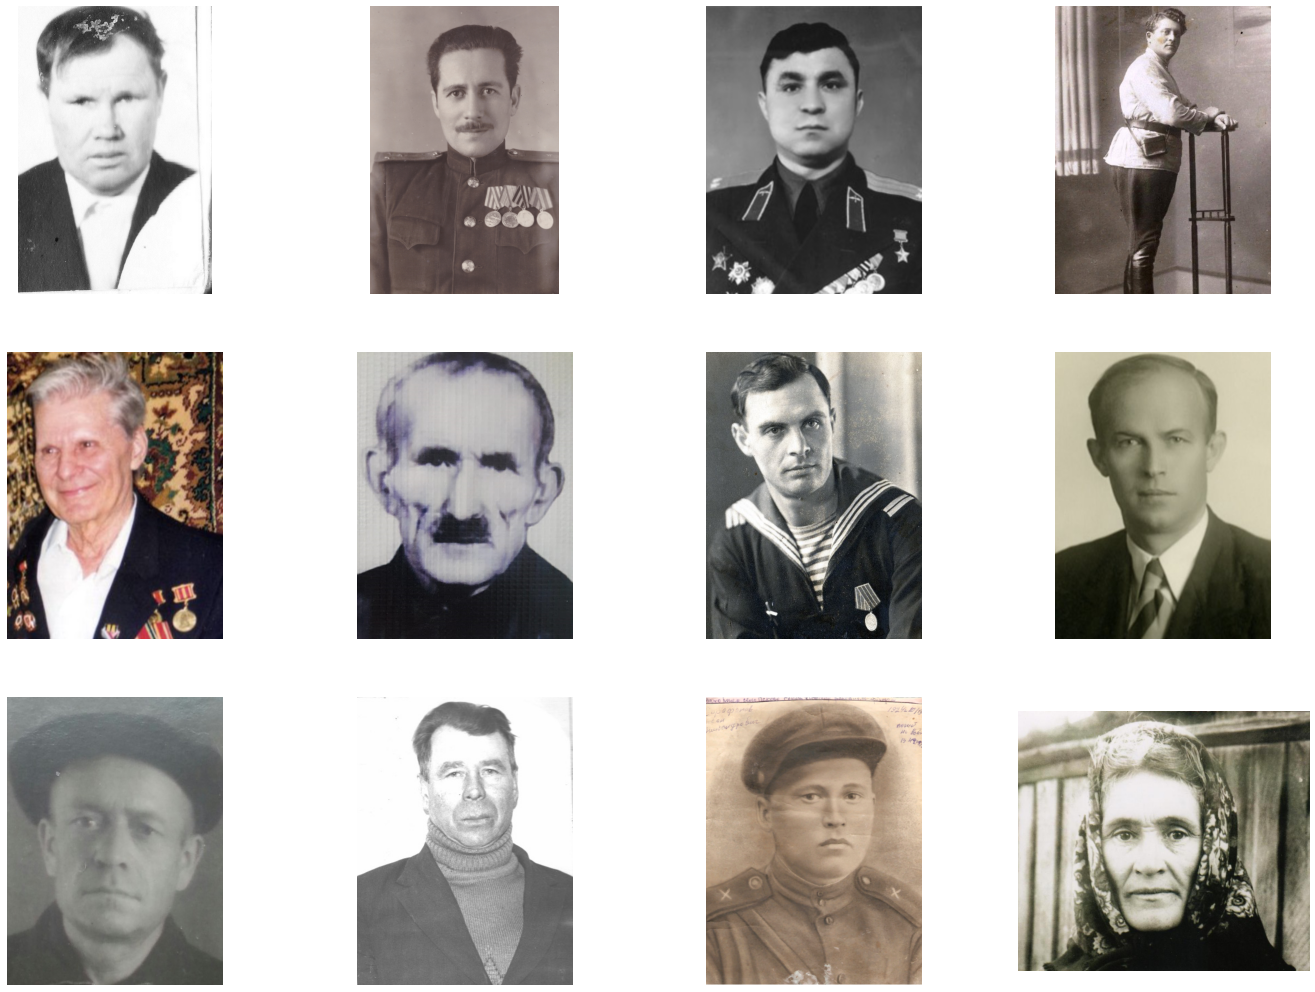

In [8]:
def get_image(url):
    res = requests.get(url)
    img = Image.open(BytesIO(res.content))
    
    return img


def plot_mosaic(image_urls):
    images = [get_image(url) for url in image_urls]
    
    fig = plt.figure(figsize=(24, 18))

    columns = 4
    rows = 3

    for i in range(1, 13):
        img = images[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.imshow(img, 'gray')

    plt.show()


plot_mosaic(df[df['photo'] != MISSING_IMAGE]['photo'].sample(12, random_state=43))

### name

**name** contains person name in format: surname name middlename. Data contains a lot of full namesakes.

In [9]:
df['name'] = df['name'].astype(str)
df['name'].value_counts()

Иванов Иван Иванович           166
Иванов Николай Иванович        155
Иванов Василий Иванович        144
Иванов Александр Иванович      123
Иванов Михаил Иванович         106
                              ... 
Салданов Бадма Булутувич         1
Дмитриев Аким Михайлович         1
Некрасов Михаил Полуэктович      1
Родионов Кирилл Григорьевич      1
Шохин Сергей Фаддеевич           1
Name: name, Length: 869763, dtype: int64

This data can be used to analyse popularity of names / surnames on different years.

In [10]:
from processing import (get_most_common_name_surname,
                        prepare_name_dict, barplot)

In [11]:
surname_1900, name_1900 = get_most_common_name_surname(df, '1900')
surname_1910, name_1910 = get_most_common_name_surname(df, '1910')
surname_1920, name_1920 = get_most_common_name_surname(df, '1920')

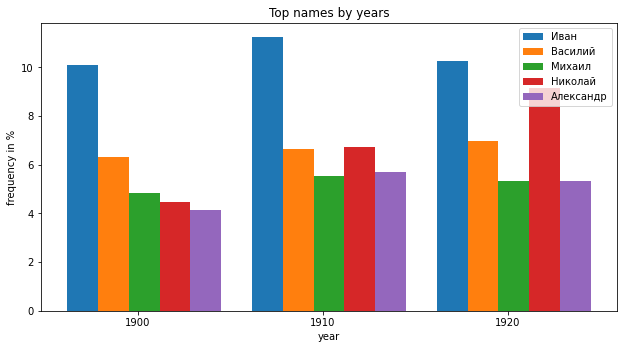

In [12]:
names_lists = prepare_name_dict([name_1900, name_1910, name_1920])
barplot(names_lists, [1900, 1910, 1920], 'names')

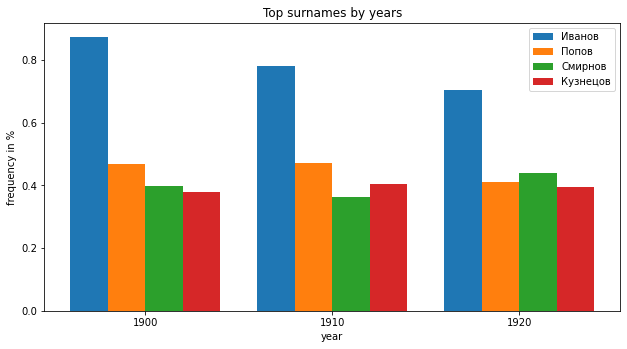

In [13]:
surnames_list = prepare_name_dict([surname_1900, surname_1910, surname_1920])
barplot(surnames_list, [1900, 1910, 1920], 'surnames')

### birth_date

**birth_date** in dataset presented in multiple formats, additional processing required to normalize dates.

In [14]:
df['birth_date'].head()

0         19.12.1913
1               1899
2         14.10.1914
3         20.02.1915
4    1924 29 декабря
Name: birth_date, dtype: object

First of all let's check textual info in dates.

In [15]:
text_dates = df['birth_date'].str.replace('[^а-яА-Я ]', '').str.strip()
text_dates.value_counts()

               1058990
г                27323
год               7164
гр                5780
мая               3070
                ...   
года января          1
феврыля              1
декабряцр            1
о гр                 1
авуста               1
Name: birth_date, Length: 2151, dtype: int64

It seems like most of data contains only numerical data. Sometimes it contains year word or letter (г, год, года) and month names. Sometimes it contains some parsing / page formatting errors.

In [16]:
from processing import process_date

In [17]:
b_days, b_months, b_years = process_date(df['birth_date'])

In [18]:
print('Missing year:', (b_years == '____').sum())
print('Missing month:', (b_months == '__').sum())
print('Missing day:', (b_days == '__').sum())

Missing year: 9456
Missing month: 795703
Missing day: 801840


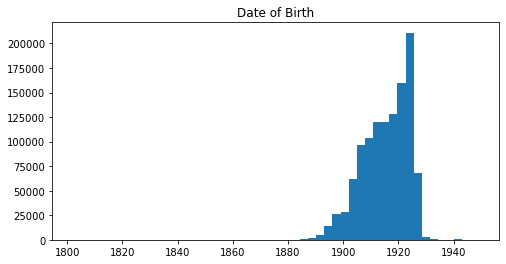

In [19]:
data_used = b_years[b_years != '____'].astype(int)

plt.figure(figsize=(8, 4))
plt.hist(data_used, 50)
plt.title('Date of Birth')
plt.show()

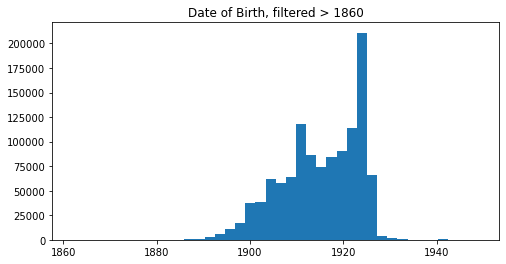

In [20]:
data_used = b_years[b_years != '____'].astype(int)
data_used = data_used[data_used > 1860]

plt.figure(figsize=(8, 4))
plt.hist(data_used, 40)
plt.title('Date of Birth, filtered > 1860')
plt.show()

In [21]:
df['birth_date'] = b_days + '.' + b_months + '.' + b_years
df['birth_date'].head()

0    19.12.1913
1    __.__.1899
2    14.10.1914
3    20.02.1915
4    29.12.1924
Name: birth_date, dtype: object

### birth_place

**birth_place** is on free format. Moreover, some places may have changed their names or no longer exist. Not sure that any geo-coder can be used with historical data.

In [22]:
def process_places(places_column):
    places = places_column.copy()
    places[places == 'нет сведений'] = None
    places[places == 'данных нет'] = None
    places[places == 'сведений нет'] = None
    places[places == 'нет данных'] = None
    
    places[places.notnull()] = places[places.notnull()].str.split('|').apply(lambda x: x[0])
    
    places = places.fillna('нет')
    
    return places

In [23]:
places = process_places(df['birth_place'])
print('Number of unique birth_place:', len(places.unique()))

Number of unique birth_place: 511576


We have tons of unique birth_places, additional processing required to normalize it to regions or something.

In [24]:
places.value_counts()[:10]

нет                               288369
ЧИАССР                              9165
г. Ленинград                        3432
г. Кинешма, Ивановской области      1964
Ивановская область                  1955
г.Ленинград                         1850
Москва                              1662
Ленинград                           1484
Алтайский край                      1482
г. Вичуга, Ивановской области       1418
Name: birth_place, dtype: int64

If no preprocessing applied we have most of persons from ЧИАССР (Чеченско Ингушетская Автономная ССР). It may be because of additional processing required (so persons from other cities specify their city, not ССР) and because of bulk uploading of data to website (so someone upload all persons from this regions from some databases). Since data doesn't contain all persons, it may be unbalanced because of this.

In [25]:
places.sample(10, random_state=42)

657416    Куйбышевская обл., Волжский р-н, с. Петра Дуброва
743589                                                  нет
748849                                      село Белая гора
208726                         с.Саюкино Тамбовской области
908752    Украинская ССР, Днепропетровская обл., п.г.т. ...
399134    д. Тайманиха, Родниковского района, Ивановской...
759792               Витебская область, деревня Сковородище
824866                    с. Михайловка Закаменского района
637411    Рязанская обл., Каверинский р-н, с. Ново-Березово
888341    Воронежская обл., Кантемировский р-н, ст. Конт...
Name: birth_place, dtype: object

Data may contain: settlement, region, autonomy (SSR). Sometimes it is splitted by comma, sometimes only by spaces.

In [26]:
from processing import parse_place_all

birth_places_df = parse_place_all(places)

In [27]:
birth_places_df.sample(10, random_state=42)

,с,рн,сср,край,д,обл,г,ст,рудник,п,х,с/с,non_parsed
657416,Петра Дуброва,Волжский,NaN,NaN,NaN,Куйбышевская,NaN,NaN,NaN,NaN,NaN,NaN,
743589,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,нет
748849,Белая,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,гора
208726,Саюкино,NaN,NaN,NaN,NaN,Тамбовская,NaN,NaN,NaN,NaN,NaN,NaN,
908752,NaN,NaN,Украинская ССР,NaN,NaN,Днепропетровская,т Широкое,NaN,NaN,NaN,NaN,NaN,п
399134,NaN,Родниковский,NaN,NaN,Тайманиха,Ивановская,NaN,NaN,NaN,NaN,NaN,NaN,
759792,NaN,NaN,NaN,NaN,Сковородище,Витебская,NaN,NaN,NaN,NaN,NaN,NaN,
824866,Михайловка,Закаменский,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
637411,Ново-Березово,Каверинский,NaN,NaN,NaN,Рязанская,NaN,NaN,NaN,NaN,NaN,NaN,
888341,NaN,Кантемировский,NaN,NaN,NaN,Воронежская,NaN,Контемира,NaN,NaN,NaN,NaN,


In [28]:
birth_places_df['сср'].value_counts()[:5]

Украинская ССР     17361
БМАССР             13508
БАССР              13279
ЧИАССР             10245
Башкирская АССР     8978
Name: сср, dtype: int64

In [29]:
birth_places_df['край'].value_counts()[:5]

Алтайский         12596
Краснодарский     10280
Ставропольский     7047
Красноярский       6141
Приморский         2537
Name: край, dtype: int64

In [30]:
birth_places_df['рн'].value_counts()[:5]

Джидинский     6617
Вичугский      4391
Тункинский     4296
Кинешемский    3659
Мичуринский    3558
Name: рн, dtype: int64

In [31]:
birth_places_df['г'].value_counts()[:5]

Ленинград    7164
Москва       2871
Кинешма      2485
Иваново      2336
Вичуга       2009
Name: г, dtype: int64

Now this places can be mapped to actual titles and used for some geo research.

### conscription_place

**conscription_place** is on free format. Moreover, some places may have changed their names or no longer exist. Not sure that any geo-coder can be used with historical data.

In [32]:
places = process_places(df['conscription_place'])
print('Number of unique conscription_place:', len(places.unique()))

Number of unique conscription_place: 210425


In [33]:
places.value_counts()[:10]

нет                                      355952
РВК Фрунзенского района г. Ленинграда     38576
ВК г. Иваново Ивановской области           9557
Котласский РВК Архангельской области       7786
Кинешемский РВК                            5950
Кяхтинским РВК                             4067
Комсомольский РВК                          3804
Вичугским РВК Ивановской области           3733
РВК Кабанского района                      3587
Родниковским РВК Ивановской области        3403
Name: conscription_place, dtype: int64

In [34]:
places.sample(10, random_state=42)

657416    Куйбышевский РВК, Куйбышевская обл., Куйбышевс...
743589                                      ЗАКАМЕНСКИМ РВК
748849                                    Чистопольский РВК
208726                 Рассказовским ГВК Тамбовской области
908752                    Тройцкий РВК, Челябинская область
399134                  Родниковским РВК Ивановской области
759792                                Ленинградская область
824866                                                  нет
637411                           Привокзальным РВК, г. Тулы
888341    Кугалинский РВК, Казахская ССР, Алма-Атинская ...
Name: conscription_place, dtype: object

### conscription_date

**conscription_date** in dataset presented in multiple formats, additional processing required to normalize dates. Same as for birth_date can be used.

In [35]:
df['conscription_date'].head()

0               1942
1               1941
2            07.1941
3         15.10.1934
4    1942 4 сентября
Name: conscription_date, dtype: object

In [36]:
c_days, c_months, c_years = process_date(df['conscription_date'].astype(str))

In [37]:
print('Missing year:', (c_years == '____').sum())
print('Missing month:', (c_months == '__').sum())
print('Missing day:', (c_days == '__').sum())

Missing year: 427374
Missing month: 756843
Missing day: 833779


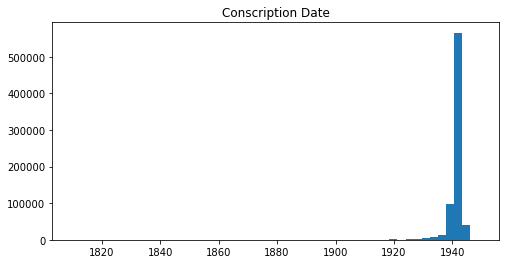

In [38]:
data_used = c_years[c_years != '____'].astype(int)

plt.figure(figsize=(8, 4))
plt.hist(data_used, 50)
plt.title('Conscription Date')
plt.show()

Once again we have some anomalies, like conscription date ~1820, which is not very realistic for partisipants of WWII.

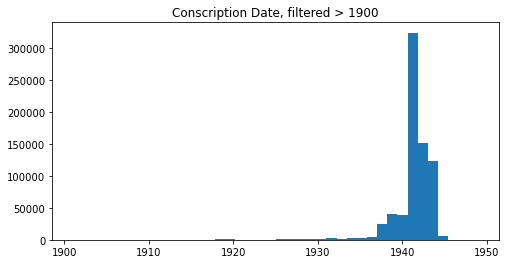

In [39]:
data_used = c_years[c_years != '____'].astype(int)
data_used = data_used[data_used > 1900]

plt.figure(figsize=(8, 4))
plt.hist(data_used, 40)
plt.title('Conscription Date, filtered > 1900')
plt.show()

In [40]:
df['conscription_date'] = c_days + '.' + c_months + '.' + c_years
df['conscription_date'].head()

0    __.__.1942
1    __.__.1941
2    __.07.1941
3    15.10.1934
4    04.09.1942
Name: conscription_date, dtype: object

### rank

**rank** are well formatted, it have some typos, but overall column quality is good.

In [41]:
df['rank'].value_counts()

рядовой                                                                          289827
красноармеец                                                                     129055
сержант                                                                           69507
лейтенант                                                                         36787
ефрейтор                                                                          28529
                                                                                  ...  
разведчик, старшина 2 статьи                                                          1
воен-инженер 3 ранга                                                                  1
помощник партизан                                                                     1
рядовой ( пехота)                                                                     1
гв.мл. лейтенант м\с. военфельдшер 372 гмд 89 гвардейского минометного полка.         1
Name: rank, Length: 27838, dtype

### duty_place

In [42]:
places = process_places(df['duty_place'])
print('Number of unique duty_place:', len(places.unique()))

Number of unique duty_place: 241243


In [43]:
places.value_counts()[:10]

нет                    791953
Ленинградский фронт      2060
-                        1350
Дальний Восток           1262
Западный фронт           1103
---                       999
Белорусский фронт         954
Нет сведений              949
Сталинград                880
Ленинград                 822
Name: duty_place, dtype: int64

### death_date

In [44]:
df['death_date'].head()

0      сведений нет
1              1965
2        21.02.2001
3        31.08.2001
4    2006 1 февраля
Name: death_date, dtype: object

In [45]:
d_days, d_months, d_years = process_date(df['death_date'].astype(str))

In [46]:
print('Missing year:', (d_years == '____').sum())
print('Missing month:', (d_months == '__').sum())
print('Missing day:', (d_days == '__').sum())

Missing year: 834679
Missing month: 706550
Missing day: 795201


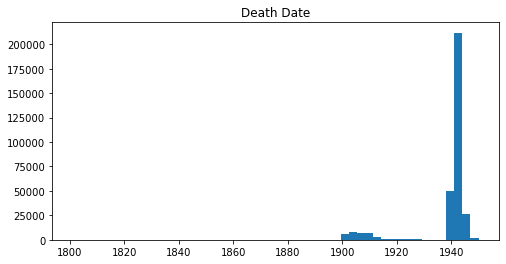

In [47]:
data_used = d_years[d_years != '____'].astype(int)
data_used = data_used[data_used < 2021]

plt.figure(figsize=(8, 4))
plt.hist(data_used, 50)
plt.title('Death Date')
plt.show()

/anaconda3/envs/op/lib/python3.6/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


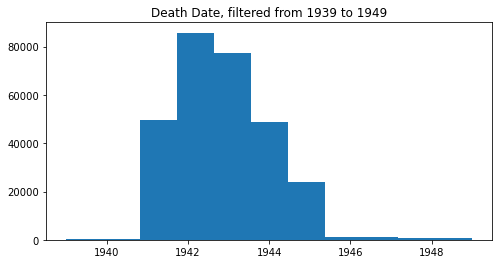

In [48]:
data_used = d_years[d_years != '____'].astype(int)
data_used = data_used[(data_used > 1938) * (data_used < 1950)]

plt.figure(figsize=(8, 4))
plt.hist(data_used, 11)
plt.title('Death Date, filtered from 1939 to 1949')
plt.show()

In [49]:
df['death_date'] = d_days + '.' + d_months + '.' + d_years
df['death_date'].head()

0    __.__.____
1    __.__.____
2    21.02.____
3    31.08.____
4    01.02.1902
Name: death_date, dtype: object

### bio

**bio** is in free format, may contain details about duty place, medals, etc.

In [50]:
df['bio'].sample(10, random_state=42)

657416                                                  NaN
743589                                                  NaN
748849                                                  NaN
208726                                                  NaN
908752                                                  NaN
399134                                                  NaN
759792                                                  NaN
824866                                                  NaN
637411    Орденом Красной Звезды, медалями За победу над...
888341                                                  NaN
Name: bio, dtype: object

In [51]:
df['bio'].value_counts()[:10]

данных нет                              38609
медаль "За победу над Германией"         2974
медаль "За боевые заслуги"               1491
Медаль "За победу над Германией"         1280
медаль "За отвагу"                       1246
нет сведений                             1233
сведений нет                             1052
орден Отечественной войны II степени      786
орден Отечественной войны 2 степени       784
Орден Отечественной войны II степени      701
Name: bio, dtype: int64

## Save processed

In [52]:
df.to_csv('data_processed.csv', index=False)